# Labeling Functions Ideas


Exploring the LFs ideas behind users meta data, propaganda techniques, and assumptions made about the task.

Focusing only on the propaganda techniques in this file.


In [1]:
import re
import glob
import emoji
import json
import random
import stanza
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline

sns.set()
%matplotlib inline

In [2]:
# defining data paths

prop_data_path = "../data/processed/propaganda.json"
gen_data_paths = "../data/processed/genuine*.json"
access_tokens_path = "../data/access_tokens.json"

prop_data_annotated = "../data/processed/propaganda_annotated.pkl"
gen_data_annotated = "../data/processed/genuine_annotated.pkl"

In [3]:
# defining HuggingFace models checkpoints

sarcasm_model_ckpt = "Bmalmotairy/marbert-finetuned-wanlp_sarcasm"
hate_model_ckpt = "Andrazp/multilingual-hate-speech-robacofi"
zeroshot_model_ckpt = "joeddav/xlm-roberta-large-xnli"

In [4]:
# loading the HuggingFace access tokens

with open(access_tokens_path) as f:
    hf_key = json.load(f)["huggingface"]["read_token"]

In [5]:
# defining the emoji count engine

em_engine = emoji.emoji_count  # this is a function

In [6]:
prop_data = pd.read_json(prop_data_path)
prop_data.head(2)

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,follower_count,following_count,account_creation_date,tweet_text,is_retweet,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,text
0,1161436140945195008,392352672,نجديه عذيه .,Ksa_FO1,نجد العذيه للدعم,مابادل اقل من ٥ الاف ولا أقبل المقدم بدون طلب ...,70616,52577,1318723200000,RT @GROB_07: #حـسـآب_تـمــيزة_بـتـفـاعـل 💫\n⠀┈...,True,0,0,0,0,3,0,2,حـسـآب تـمــيزة بـتـفـاعـل ⠀┈┉━◈♔♚♔◈━┅┄ نجــــ...
1,764273648496742400,4708503082,ْ‏ོ جود العبداللّهہ|| ོالتنبيهات ما توصل,j06__,None,‏‏‏‏‏‏‏‏‏‏‏إنه يستجيب منذُ أن دعوُت ولگِن يُدب...,60061,2617,1451865600000,اللهم اكثر من امثالي ليعم الخير و تعم السعادة ...,False,0,0,0,0,1,0,0,اللهم اكثر من امثالي ليعم الخير و تعم السعادة ...


In [7]:
prop_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56000 entries, 0 to 55999
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweetid                   56000 non-null  int64 
 1   userid                    56000 non-null  object
 2   user_display_name         56000 non-null  object
 3   user_screen_name          56000 non-null  object
 4   user_reported_location    36366 non-null  object
 5   user_profile_description  51749 non-null  object
 6   follower_count            56000 non-null  int64 
 7   following_count           56000 non-null  int64 
 8   account_creation_date     56000 non-null  int64 
 9   tweet_text                56000 non-null  object
 10  is_retweet                56000 non-null  bool  
 11  quote_count               56000 non-null  int64 
 12  reply_count               56000 non-null  int64 
 13  like_count                56000 non-null  int64 
 14  retweet_count             5

In [8]:
files = glob.glob(gen_data_paths)
files

['../data/processed\\genuine_banking.json',
 '../data/processed\\genuine_gov.json',
 '../data/processed\\genuine_jour.json',
 '../data/processed\\genuine_news.json',
 '../data/processed\\genuine_sports.json',
 '../data/processed\\genuine_univ.json']

In [9]:
dfs = [pd.read_json(f) for f in files]

In [10]:
# the following lines are to handle old version of genuine data (banking - sports).

# dfs = [
#     pd.read_json(f)
#     for f in files
#     if f.endswith("banking.json") or f.endswith("sports.json")
# ]

In [11]:
gen_data = pd.concat(dfs, ignore_index=True).drop_duplicates(subset=["tweetid"])
gen_data.head(2)

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,follower_count,following_count,account_creation_date,tweet_text,is_retweet,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,text
0,1526234562359066624,947365777,بنك التنمية الاجتماعية,SDB_sa,Kingdom of Saudi Arabia,بنك التنمية الاجتماعية، أحد الركائز الحكومية ا...,409379.0,12.0,2012-11-14T08:50:59.000Z,الفائز بالمركز الثالث في #هاكثون_الادخار #وزين...,False,0.0,1.0,8,2.0,2,1,0,الفائز بالمركز الثالث في هاكثون الادخار وزين ف...
1,1488090545981378568,2321495687,إمارة المنطقة الشرقية,emara_sharqia,None,الحساب الرسمي لـ #إمارة_المنطقة_الشرقية - المم...,477714.0,7.0,2014-02-03T08:49:37.000Z,استقبل صاحب السمو الملكي الأمير سعود بن نايف\n...,False,0.0,5.0,32,27.0,1,2,0,استقبل صاحب السمو الملكي الأمير سعود بن نايف أ...


In [12]:
gen_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140612 entries, 0 to 148624
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   tweetid                   140610 non-null  object 
 1   userid                    140611 non-null  object 
 2   user_display_name         131651 non-null  object 
 3   user_screen_name          131651 non-null  object 
 4   user_reported_location    109839 non-null  object 
 5   user_profile_description  131335 non-null  object 
 6   follower_count            131651 non-null  float64
 7   following_count           131651 non-null  float64
 8   account_creation_date     131651 non-null  object 
 9   tweet_text                140612 non-null  object 
 10  is_retweet                140612 non-null  bool   
 11  quote_count               140607 non-null  float64
 12  reply_count               140608 non-null  float64
 13  like_count                140608 non-null  object

In [13]:
prop_data["emojis"] = prop_data.tweet_text.apply(em_engine)
gen_data["emojis"] = gen_data.tweet_text.apply(em_engine)

<Axes: xlabel='urls', ylabel='Count'>

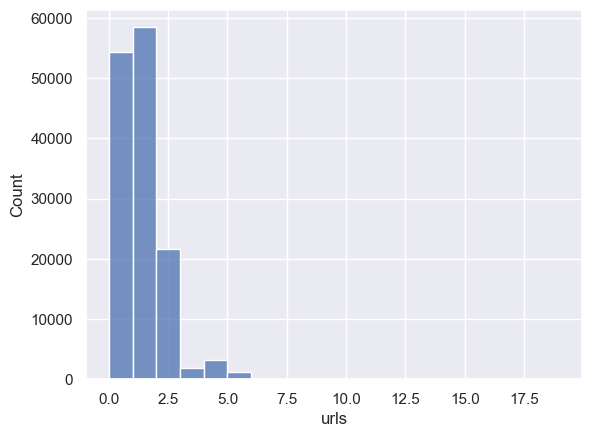

In [14]:
sns.histplot(gen_data.urls, bins=np.arange(0, 20, 1))

<Axes: xlabel='urls', ylabel='Count'>

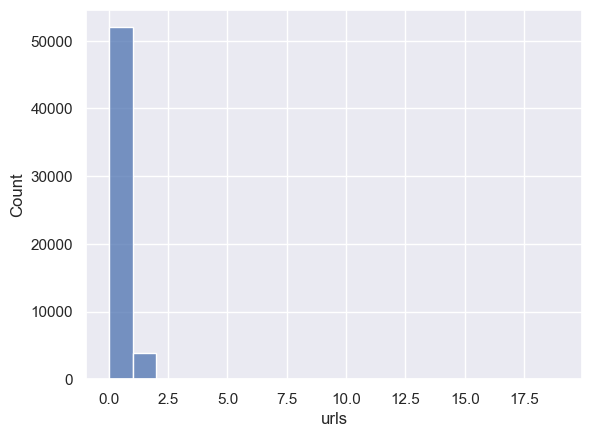

In [15]:
sns.histplot(prop_data.urls, bins=np.arange(0, 20, 1))

It seems that genuine users tend to add `at least one URL` in their tweets. On the other hand, propagandist users tend to `ignore adding any URLs`.


<Axes: xlabel='hashtags', ylabel='Count'>

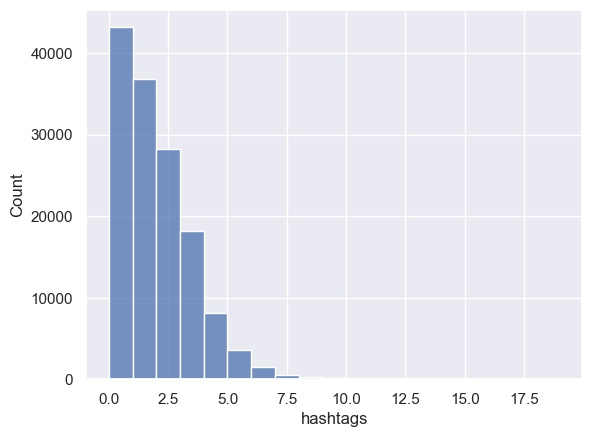

In [16]:
sns.histplot(gen_data.hashtags, bins=np.arange(0, 20, 1))

<Axes: xlabel='hashtags', ylabel='Count'>

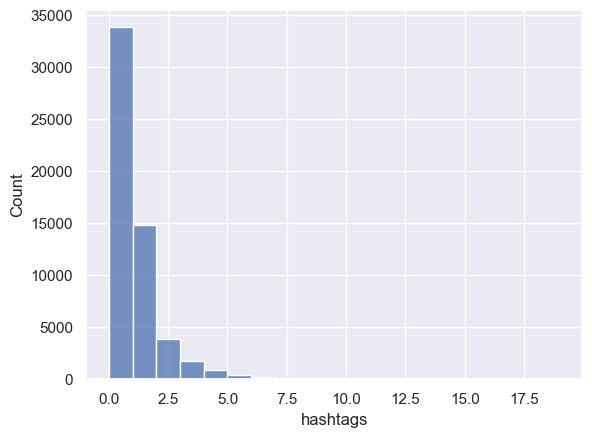

In [17]:
sns.histplot(prop_data.hashtags, bins=np.arange(0, 20, 1))

Hashtags are equivalently present in both categories (gen, prop).


<Axes: xlabel='emojis', ylabel='Count'>

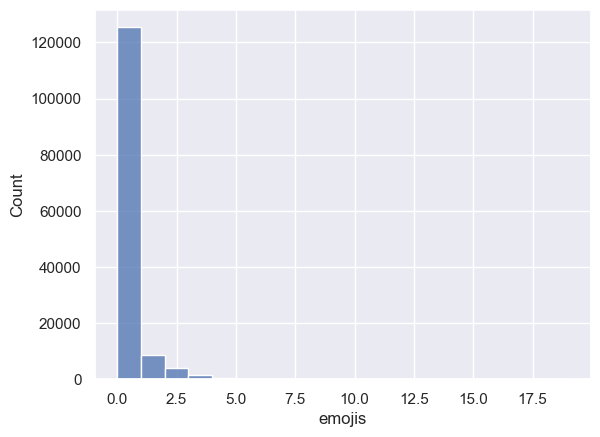

In [18]:
sns.histplot(gen_data.emojis, bins=np.arange(0, 20, 1))

<Axes: xlabel='emojis', ylabel='Count'>

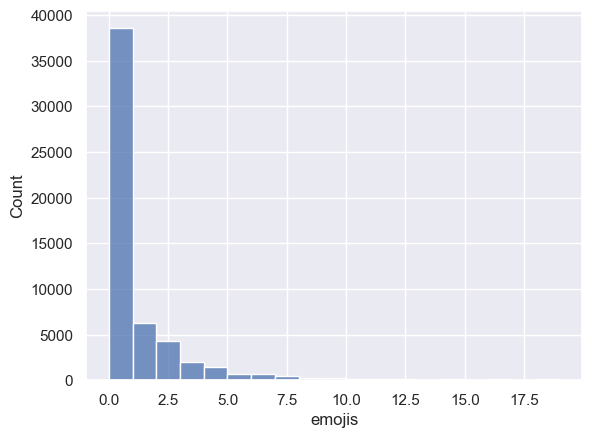

In [19]:
sns.histplot(prop_data.emojis, bins=np.arange(0, 20, 1))

No difference in the two worlds.


<Axes: xlabel='user_mentions', ylabel='Count'>

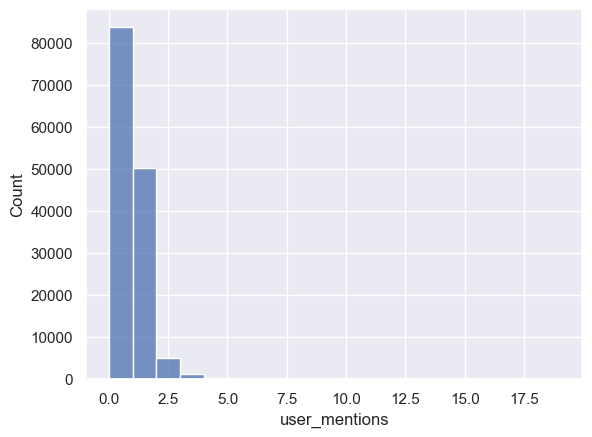

In [20]:
sns.histplot(gen_data.user_mentions, bins=np.arange(0, 20, 1))

<Axes: xlabel='user_mentions', ylabel='Count'>

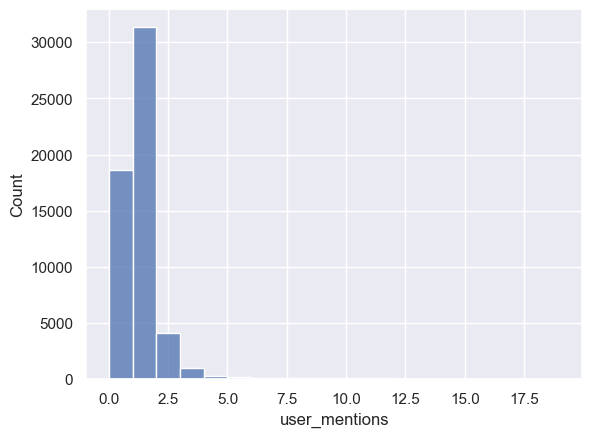

In [21]:
sns.histplot(prop_data.user_mentions, bins=np.arange(0, 20, 1))

It seems that propagandists tend to mention at least one person in the tweet as opposite to genuine users. But, does a propagandist mention themselves in their tweets?


In [22]:
mentions_engine = re.compile(r"@\w+")

prop_self_mentions = [
    r.user_screen_name in mentions_engine.findall(r.tweet_text)
    for _, r in tqdm(prop_data.iterrows(), total=len(prop_data))
]

  0%|          | 0/56000 [00:00<?, ?it/s]

In [23]:
pd.Series(prop_self_mentions).value_counts()

False    56000
Name: count, dtype: int64

In [24]:
gen_self_mentions = [
    r.user_screen_name in mentions_engine.findall(r.tweet_text)
    for _, r in tqdm(gen_data.iterrows(), total=len(gen_data))
]

  0%|          | 0/140612 [00:00<?, ?it/s]

In [25]:
pd.Series(gen_self_mentions).value_counts()

False    140612
Name: count, dtype: int64

No self-mentions at all.


In [26]:
# word count in all tweets with stop words

gen_data["word_count"] = gen_data.text.apply(lambda x: len(word_tokenize(x)))
prop_data["word_count"] = prop_data.text.apply(lambda x: len(word_tokenize(x)))

<Axes: xlabel='word_count', ylabel='Count'>

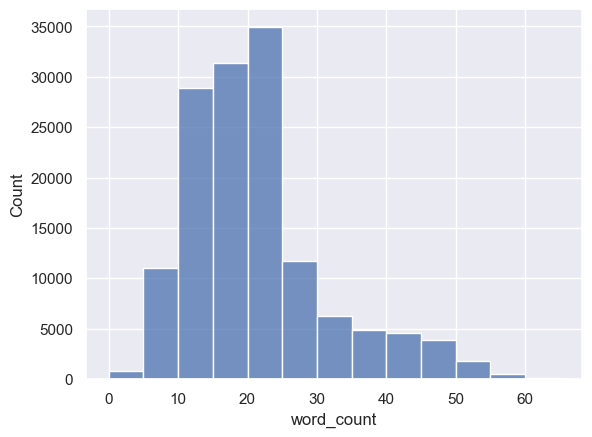

In [27]:
sns.histplot(gen_data.word_count, bins=np.arange(0, 70, 5))

<Axes: xlabel='word_count', ylabel='Count'>

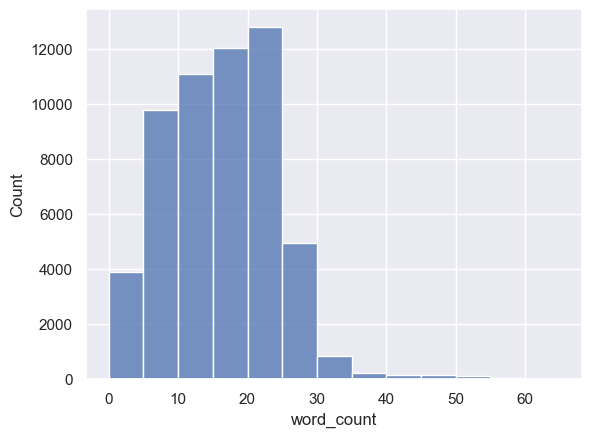

In [28]:
sns.histplot(prop_data.word_count, bins=np.arange(0, 70, 5))

We have some propagandist users tweet in less than 5 words. But, do these tweets contain propaganda techniques? we will find out by providing number of words as a propaganda flag.


In [29]:
# word cloud with stop words

gen_words, prop_words = [], []

for _, r in gen_data.iterrows():
    if not pd.isna(r.text):
        gen_words.extend(word_tokenize(r.text))

for _, r in prop_data.iterrows():
    if not pd.isna(r.user_profile_description):
        prop_words.extend(word_tokenize(r.text))

In [30]:
pd.Series(gen_words).value_counts()[:10]

في       67687
.        51074
من       45532
:        38218
..       34153
ولي      30447
العهد    29211
على      27512
بن       19569
أسعار    17673
Name: count, dtype: int64

In [31]:
pd.Series(prop_words).value_counts()[:10]

الله     14420
من       13558
.        12306
في        9763
..        7725
:         7599
لا        6257
على       5749
،         5431
اللهم     5175
Name: count, dtype: int64

In [32]:
# word cloud without stop words

sw = stopwords.words("arabic")
random.sample(sw, 10)

['شباط',
 'أ',
 'اللذين',
 'بماذا',
 'تسعة',
 'أجل',
 'الألى',
 'هَؤلاء',
 'ثالث',
 'بئس']

In [33]:
gen_words_sw = list(np.array(gen_words)[~np.in1d(gen_words, sw)])
prop_words_sw = list(np.array(prop_words)[~np.in1d(prop_words, sw)])

In [34]:
pd.Series(gen_words_sw).value_counts()[:10].index.tolist()

['.', ':', '..', 'ولي', 'العهد', 'بن', 'أسعار', "''", '``', 'سمو']

In [35]:
pd.Series(prop_words_sw).value_counts()[:10].index.tolist()

['الله', '.', '..', ':', '،', 'اللهم', '!', 'قروب', '(', 'للدعم']

Loaded language key words should be extacted from the most repeated words by propagandists.


In [36]:
# multiple preprocessing steps using stanza pipeline

stanza.download("ar")
arnlp = stanza.Pipeline("ar", verbose=True, download_method=None)

2023-10-23 18:27:35 INFO: Downloading default packages for language: ar (Arabic) ...
2023-10-23 18:27:36 INFO: File exists: C:\Users\ehhho\stanza_resources\ar\default.zip
2023-10-23 18:27:39 INFO: Finished downloading models and saved to C:\Users\ehhho\stanza_resources.
2023-10-23 18:27:39 INFO: Loading these models for language: ar (Arabic):
| Processor | Package |
-----------------------
| tokenize  | padt    |
| mwt       | padt    |
| pos       | padt    |
| lemma     | padt    |
| depparse  | padt    |
| ner       | aqmar   |

2023-10-23 18:27:39 INFO: Using device: cuda
2023-10-23 18:27:39 INFO: Loading: tokenize
2023-10-23 18:27:47 INFO: Loading: mwt
2023-10-23 18:27:47 INFO: Loading: pos
2023-10-23 18:27:48 INFO: Loading: lemma
2023-10-23 18:27:48 INFO: Loading: depparse
2023-10-23 18:27:49 INFO: Loading: ner
2023-10-23 18:27:50 INFO: Done loading processors!


In [37]:
docs = [stanza.Document([], text=t) for t in gen_data.text.to_list()]
docs = arnlp(docs)

In [38]:
gen_data["docs"] = docs

In [39]:
docs = [stanza.Document([], text=t) for t in prop_data.text.to_list()]
docs = arnlp(docs)

In [40]:
prop_data["docs"] = docs

In [41]:
# getting the number of entities per tweet

gen_num_ents = [len(es.entities) for es in gen_data.docs]
prop_num_ents = [len(es.entities) for es in prop_data.docs]

<Axes: ylabel='Count'>

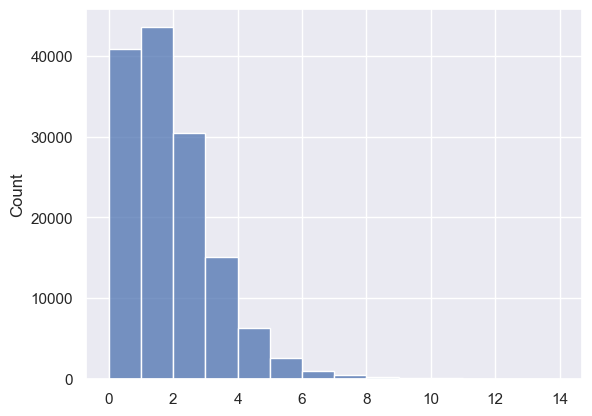

In [42]:
sns.histplot(gen_num_ents, bins=np.arange(0, 15, 1))

<Axes: ylabel='Count'>

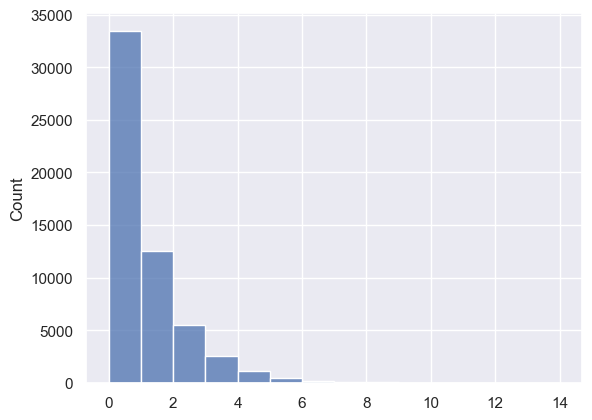

In [43]:
sns.histplot(prop_num_ents, bins=np.arange(0, 15, 1))

Same distribution and no difference.


In [5]:
import torch

# remove stanza model from GPU
arnlp = None

# clear GPU memory
torch.cuda.empty_cache()

In [6]:
batch_size = 256

In [50]:
# sarcasm speech detection

sarcasm_model = pipeline(
    task="text-classification",
    model=sarcasm_model_ckpt,
    batch_size=batch_size,
    device="cuda",
    token=hf_key,
)

In [51]:
print(f"Text: {gen_data.text[0]}\nClassification: {sarcasm_model(gen_data.text[0])}")

Text: الفائز بالمركز الثالث في هاكثون الادخار وزين فريق إيزان بفكرة تطبيق يختص بالتقنية المالية الشخصية من تتبع وادارة المصاريف والحصول على قروض مصغرة.
Classification: [{'label': 'Non-Sarcasm', 'score': 0.9976761937141418}]


In [52]:
sarcasm_preds = sarcasm_model(gen_data.text.to_list())
gen_data["sarcasm"] = sarcasm_preds

In [53]:
pd.Series([t["label"] for t in gen_data.sarcasm]).value_counts()

Non-Sarcasm    139121
Sarcasm          1491
Name: count, dtype: int64

In [54]:
sarcasm_preds = sarcasm_model(prop_data.text.to_list())
prop_data["sarcasm"] = sarcasm_preds

In [55]:
pd.Series([t["label"] for t in prop_data.sarcasm]).value_counts()

Non-Sarcasm    55111
Sarcasm          889
Name: count, dtype: int64

In [56]:
# for the technique of name calling or labeling,
# are there any sarcasm tweets that contain entities?

name_calling = []
for _, r in prop_data.iterrows():
    name_calling.append(len(r.docs.entities) and r.sarcasm["label"] == "Sarcasm")

pd.Series(name_calling).value_counts()

0       55547
True      453
Name: count, dtype: int64

We can assume that we have 0.5K tweets by propagandists that contain the name calling technique.


In [57]:
name_calling = []
for _, r in gen_data.iterrows():
    name_calling.append(len(r.docs.entities) and r.sarcasm["label"] == "Sarcasm")

pd.Series(name_calling).value_counts()

False    139538
True       1074
Name: count, dtype: int64

Also, We can assume that we have 1K tweets by genuine users that contain the name calling technique.


In [58]:
# trying to detect the doubt technique by detecting questions
# the doubt question ar mainly 'هل', so we will be detecting auxs

gen_contain_q = []
for doc in gen_data.docs:
    contain = False
    if len(doc.sentences) != 0:
        for word in doc.sentences[0].words:
            if word.upos == "AUX":
                contain = True
                break
    gen_contain_q.append(contain)

In [59]:
pd.Series(gen_contain_q).value_counts()

False    128314
True      12298
Name: count, dtype: int64

In [60]:
prop_contain_q = []
for doc in prop_data.docs:
    contain = False
    for word in doc.sentences[0].words:
        if word.upos == "AUX":
            contain = True
            break
    prop_contain_q.append(contain)

In [61]:
pd.Series(prop_contain_q).value_counts()

False    52524
True      3476
Name: count, dtype: int64

We have around 15.5K tweets in the entire datasets that contain at least one question.


In [62]:
# remove sarcasm model from GPU
sarcasm_model = None

# clear GPU memory
torch.cuda.empty_cache()

In [63]:
# detecting the hate speech signal distributions

hate_model = pipeline(
    task="text-classification",
    model=hate_model_ckpt,
    batch_size=batch_size,
    device="cuda",
    token=hf_key,
)

In [64]:
hate_preds = hate_model(gen_data.text.to_list())
gen_data["hate"] = hate_preds

In [65]:
pd.Series([t["label"] for t in gen_data.hate]).value_counts()

not offensive    137980
offensive          2632
Name: count, dtype: int64

In [66]:
hate_preds = hate_model(prop_data.text.to_list())
prop_data["hate"] = hate_preds

In [67]:
pd.Series([t["label"] for t in prop_data.hate]).value_counts()

not offensive    53603
offensive         2397
Name: count, dtype: int64

In total, we have around 5K tweets that contain hate speech. This is also related to the name calling and smears techniques.


In [68]:
# remove hate model from GPU
hate_model = None

# clear GPU memory
torch.cuda.empty_cache()

In [73]:
gen_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140612 entries, 0 to 148624
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   tweetid                   140610 non-null  object 
 1   userid                    140611 non-null  object 
 2   user_display_name         131651 non-null  object 
 3   user_screen_name          131651 non-null  object 
 4   user_reported_location    109839 non-null  object 
 5   user_profile_description  131335 non-null  object 
 6   follower_count            131651 non-null  float64
 7   following_count           131651 non-null  float64
 8   account_creation_date     131651 non-null  object 
 9   tweet_text                140612 non-null  object 
 10  is_retweet                140612 non-null  bool   
 11  quote_count               140607 non-null  float64
 12  reply_count               140608 non-null  float64
 13  like_count                140608 non-null  object

In [74]:
prop_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56000 entries, 0 to 55999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweetid                   56000 non-null  int64 
 1   userid                    56000 non-null  object
 2   user_display_name         56000 non-null  object
 3   user_screen_name          56000 non-null  object
 4   user_reported_location    36366 non-null  object
 5   user_profile_description  51749 non-null  object
 6   follower_count            56000 non-null  int64 
 7   following_count           56000 non-null  int64 
 8   account_creation_date     56000 non-null  int64 
 9   tweet_text                56000 non-null  object
 10  is_retweet                56000 non-null  bool  
 11  quote_count               56000 non-null  int64 
 12  reply_count               56000 non-null  int64 
 13  like_count                56000 non-null  int64 
 14  retweet_count             5

In [84]:
# removing any text that has only white spaces

gen_data = gen_data[[bool(len(t.strip())) for t in gen_data.text]]
prop_data = prop_data[[bool(len(t.strip())) for t in prop_data.text]]

In [7]:
# gen_data.to_pickle(gen_data_annotated)
# prop_data.to_pickle(prop_data_annotated)

# gen_data = pd.read_pickle(gen_data_annotated)
prop_data = pd.read_pickle(prop_data_annotated)

In [8]:
# utilizing the xlm roberta zeroshot model

xlmroberta_model = pipeline(
    task="zero-shot-classification",
    model=zeroshot_model_ckpt,
    batch_size=batch_size,
    torch_dtype=torch.bfloat16,
    device="cuda",
    token=hf_key,
)

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
candidate_labels = ["transparent", "propaganda"]

In [12]:
xlmroberta_preds = xlmroberta_model(gen_data.text.to_list(), candidate_labels)
gen_data["xlmroberta_label"] = xlmroberta_preds

In [14]:
gen_data.to_pickle(gen_data_annotated)

In [11]:
xlmroberta_preds = xlmroberta_model(prop_data.text.to_list(), candidate_labels)
prop_data["xlmroberta_label"] = xlmroberta_preds

In [12]:
prop_data.to_pickle(prop_data_annotated)

In [13]:
# remove xlmroberta model from GPU
xlmroberta_model = None

# clear GPU memory
torch.cuda.empty_cache()

### Colclusions

- Genuine users add `at least one URL` in their tweets.
- Propagandist users use `mentions` `at lest one time` in their tweets.
- Some propagandist users tweet in less than 5 words. (ignored, already a cluster)
- The word `حرب` is of the `top 50` used words in the propagandists tweets.
